# Face Recognition using Eigenfaces and SVM

Eigenfaces implementation in python and prediction using Support Vector Machine (SVM)
<blockquote>
Read more about Eigenfaces at : https://en.wikipedia.org/wiki/Eigenface
</blockquote>


In [116]:
# Importing libraries for Visualization
import time
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (12, 7)
rcParams['font.size'] = 12
plt.style.use('ggplot')
%matplotlib inline

In [110]:
# Import Libraries for Machine Learning and Prediction
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

In [99]:
# Loading the data
lfw_data = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [100]:
# Checking out the object attributes
lfw_data.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [101]:
lfw_data['DESCR']

'LFW faces dataset'

In [102]:
# Introspect the images to find the shapes (for plotting)
n_samples, h, w = lfw_data.images.shape
print('Samples : {}, height : {}, width : {}'.format(n_samples, h, w))

Samples : 981, height : 50, width : 37


In [103]:
# For Machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_data['data']
n_features = X.shape[1]

In [104]:
# Label to predict is the id of the person
y = lfw_data['target']
target_names = lfw_data['target_names']
n_classes = target_names.shape[0]

In [105]:
print('Total Dataset Size : ')
print('n_samples : ', n_samples)
print('n_features : ', n_features)
print('n_classes : ', n_classes)

Total Dataset Size : 
n_samples :  981
n_features :  1850
n_classes :  5


In [106]:
# Split data into training, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [107]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print('Extracting the top {} eigenfaces from {} faces'.format(n_components, X_train.shape[0]))
t0 = time.time()
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train)
print('Completed task in {}s'.format(time.time() - t0))

Extracting the top 150 eigenfaces from 686 faces
Completed task in 0.4085972309112549s


In [108]:
eigenfaces = pca.components_.reshape((n_components, h, w))
print(eigenfaces.shape)

(150, 50, 37)


In [89]:
print('Projecting the input data to the eigenfaces orthonormal basis')
t0 = time.time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Completed task in {}s'.format(time.time() - t0))

Projecting the input data to the eigenfaces orthonormal basis
Completed task in 0.022550582885742188s


In [90]:
# Train a SVM Classification Model
print('Fitting Classifier to the Training set')
t0 = time.time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print('Done in {}s'.format(time.time() - t0))
print('Best estimator found by grid search : ')
print(clf.best_estimator_)

Fitting Classifier to the Training set
Done in 32.83523178100586s
Best estimator found by grid search : 
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [91]:
# Evaluation of the model on the test set
t0 = time.time()
predictions = clf.predict(X_test_pca)
print('Done in {}s'.format(time.time() - t0))

Done in 0.040573835372924805s


In [92]:
print(classification_report(y_test, predictions, target_names=target_names))
print(confusion_matrix(y_test, predictions, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.90      0.88        20
  Donald Rumsfeld       0.81      0.79      0.80        38
    George W Bush       0.87      0.94      0.90       156
Gerhard Schroeder       0.86      0.69      0.76        35
       Tony Blair       0.85      0.74      0.79        46

      avg / total       0.86      0.86      0.85       295

[[ 18   1   1   0   0]
 [  3  30   5   0   0]
 [  0   4 147   2   3]
 [  0   1   7  24   3]
 [  0   1   9   2  34]]


In [93]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure()
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [94]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

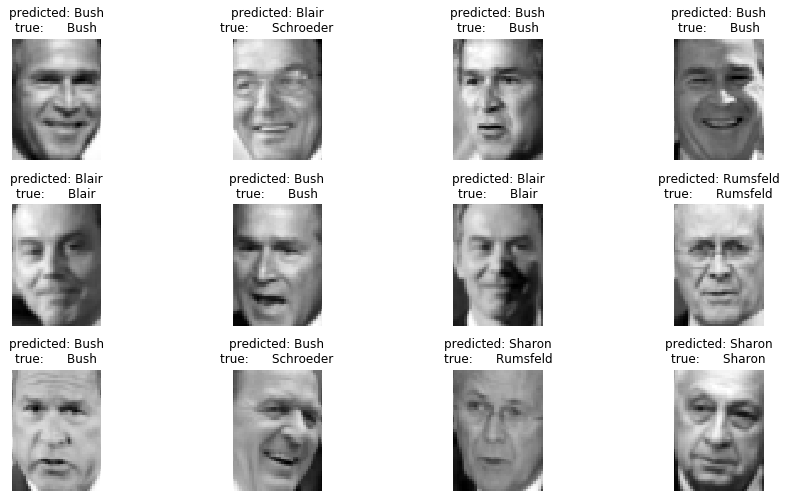

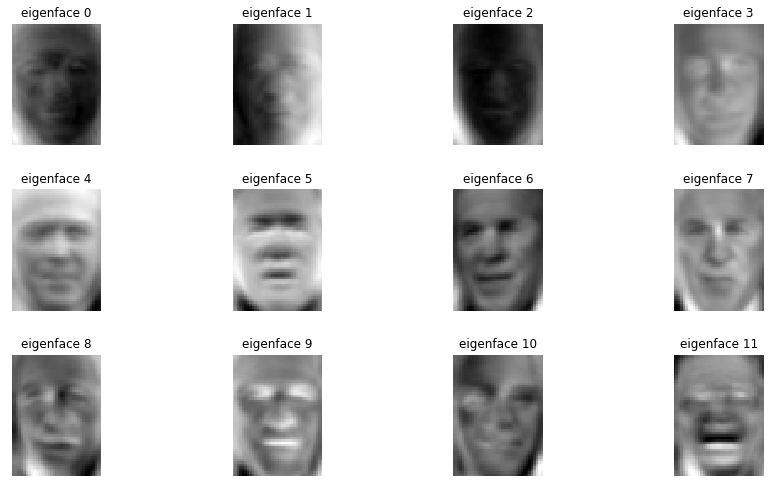

In [95]:
prediction_titles = [title(predictions, y_test, target_names, i)
                     for i in range(predictions.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)